In [71]:
#import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split



In [72]:
#loading data
data = pd.read_csv(r"heart_cleveland_upload.csv")
data.describe()
data.info()
print(data.isnull().sum())
data.columns
data.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB
age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
conditio

age            int64
sex            int64
cp             int64
trestbps       int64
chol           int64
fbs            int64
restecg        int64
thalach        int64
exang          int64
oldpeak      float64
slope          int64
ca             int64
thal           int64
condition      int64
dtype: object

In [73]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
g_labels = ['Male', 'Female']
c_labels = ['No', 'Yes']
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=g_labels, values=data['sex'].value_counts(), name="Gender"),
              1, 1)
fig.add_trace(go.Pie(labels=c_labels, values=data['condition'].value_counts(), name="condition"),
              1, 2)


fig.update_traces(hole=.4, hoverinfo="label+percent+name", textfont_size=16)

fig.update_layout(
    title_text="Gender and condition Distributions",

    annotations=[dict(text='Gender', x=0.19, y=0.5, font_size=20, showarrow=False),
                 dict(text='condition', x=0.82, y=0.5, font_size=20, showarrow=False)])
fig.show()

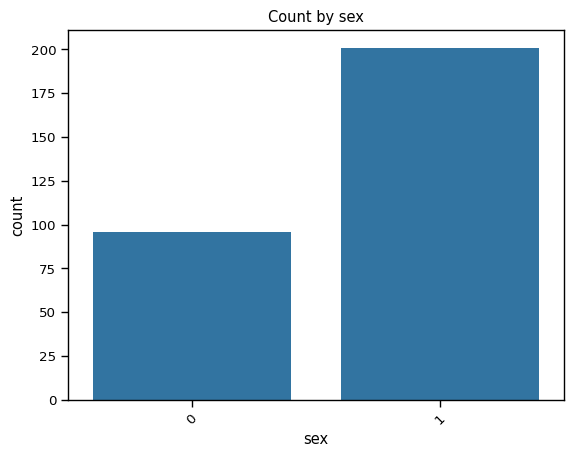

In [74]:

sns.countplot(x='sex', data=data)
plt.title("Count by sex"); plt.xticks(rotation=45); plt.show()
#male=1 , female=0

<Axes: xlabel='trestbps', ylabel='Count'>

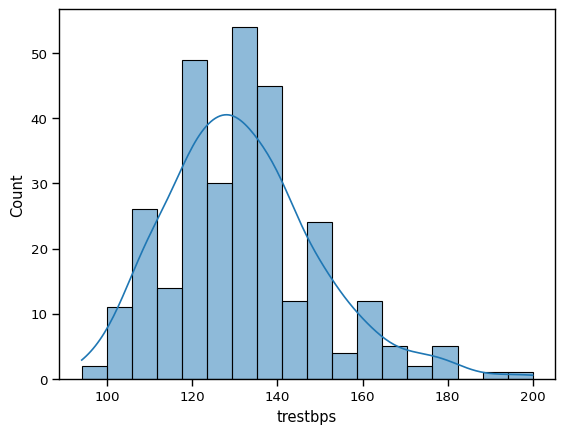

In [75]:
sns.histplot(data["trestbps"], kde=True)

<Axes: xlabel='chol', ylabel='Count'>

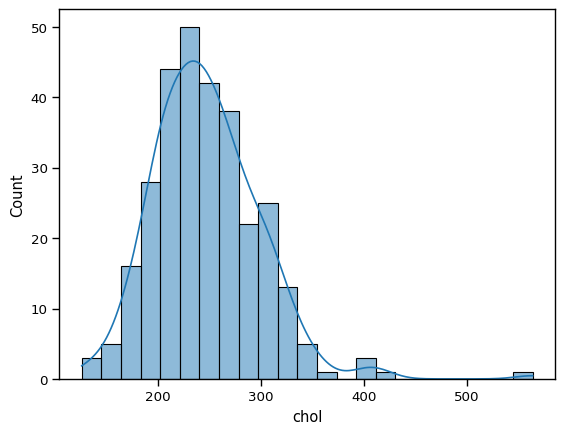

In [76]:
sns.histplot(data["chol"], kde=True)

<Axes: xlabel='thalach', ylabel='Count'>

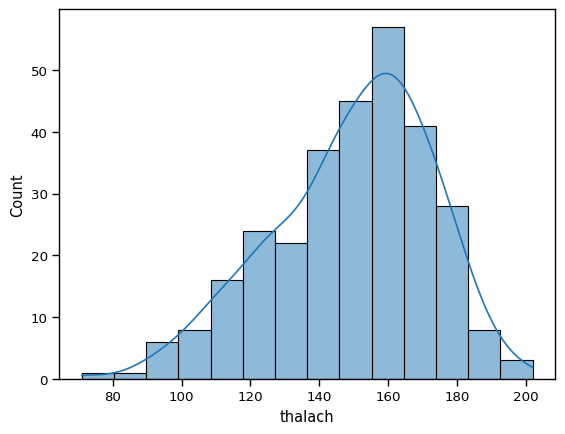

In [77]:
sns.histplot(data["thalach"], kde=True)

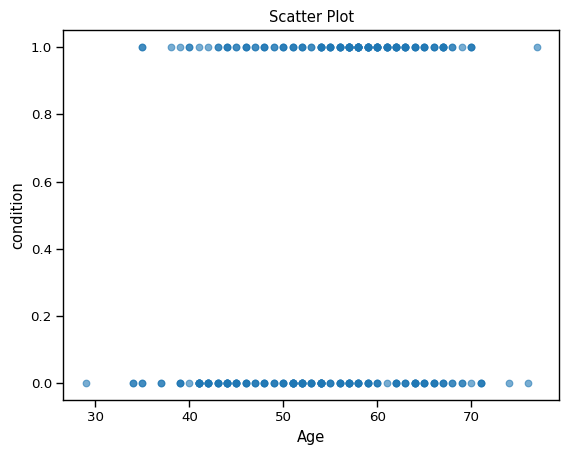

In [78]:
plt.scatter(data['age'], data['condition'], alpha=0.6)
plt.xlabel("Age"); plt.ylabel("condition"); plt.title("Scatter Plot"); plt.show()

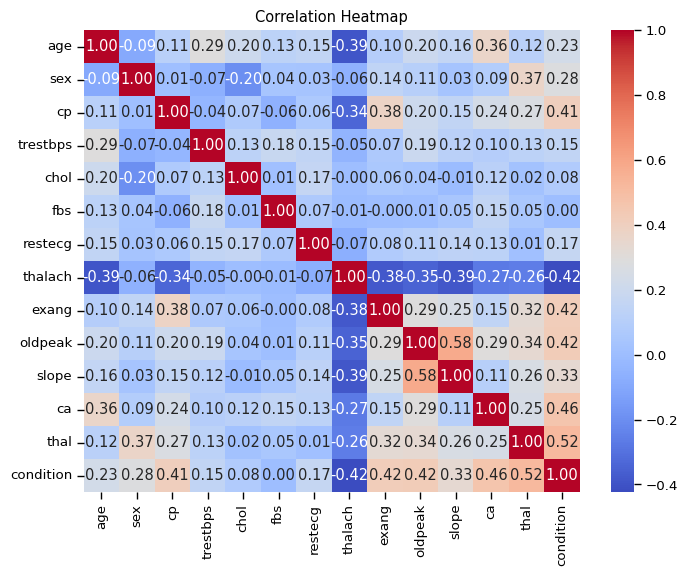

In [79]:
plt.figure(figsize=(8,6))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

(237, 13) (237,)
RandomForestClassifier  accuracy score is 0.8312236286919831 


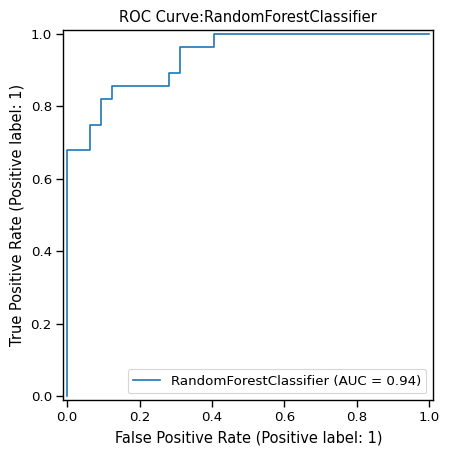

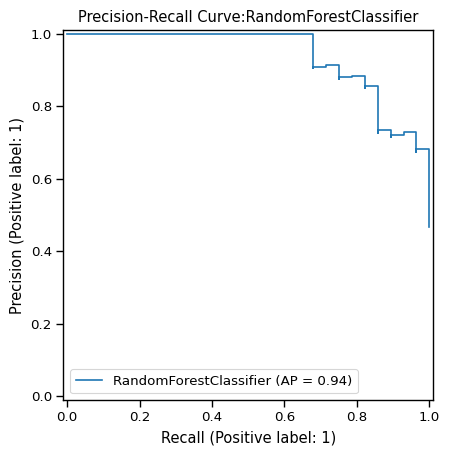

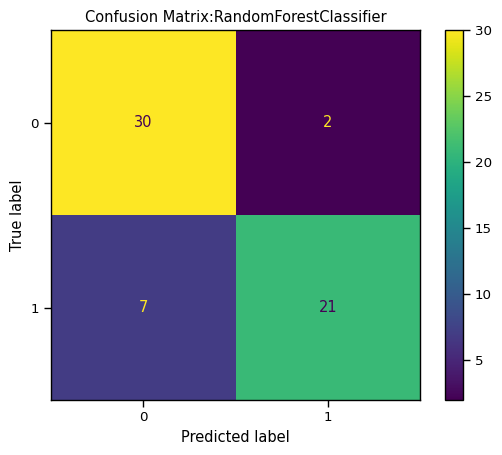

GradientBoostingClassifier  accuracy score is 0.9957805907172996 


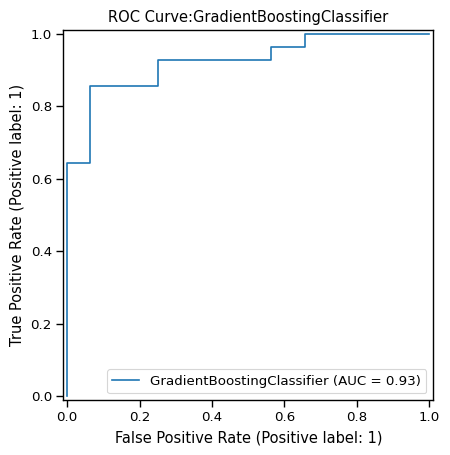

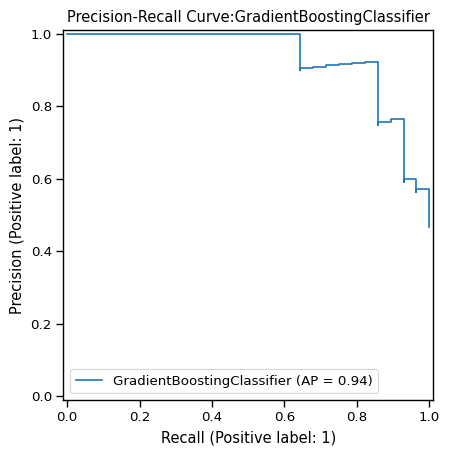

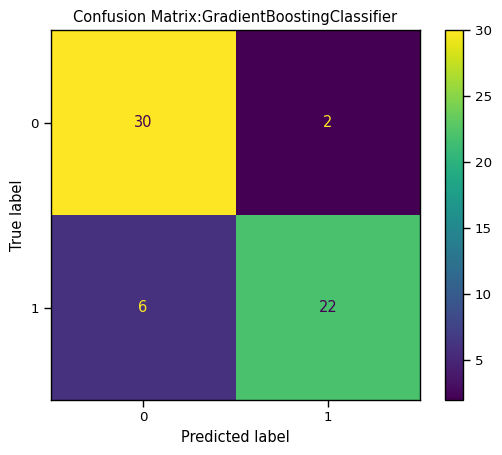

LogisticRegression  accuracy score is 0.8481012658227848 


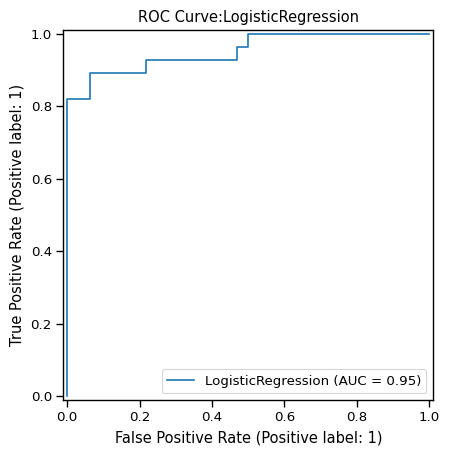

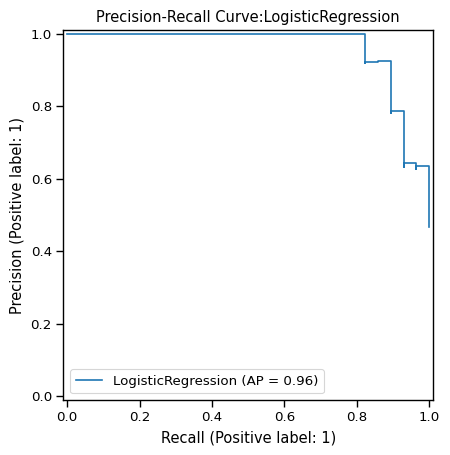

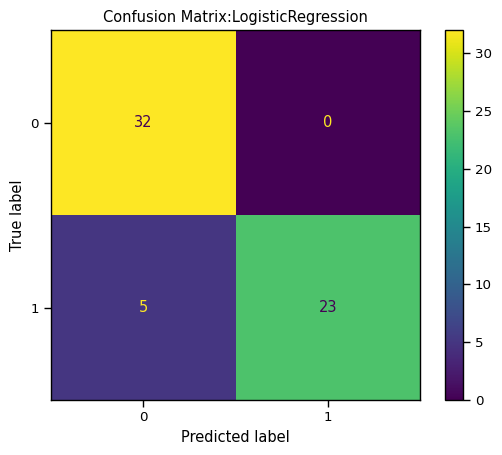

In [80]:
#Modeling
x=data.drop(["condition"] , axis=1)
y=data["condition"]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x = scaler.fit_transform(x)

x_train , x_test , y_train , y_test =model_selection.train_test_split(x ,y , test_size=0.2,random_state=42 , stratify=y)
print(x_train.shape , y_train.shape) , x_test , y_test
from sklearn.metrics import (RocCurveDisplay, PrecisionRecallDisplay,
                             ConfusionMatrixDisplay,
                             mean_squared_error, r2_score)




modeles={"RandomForestClassifier":RandomForestClassifier( n_estimators=500,       
    max_depth=6,             
    min_samples_split=50,   
    min_samples_leaf=20,    
    max_features=0.3,       
    class_weight="balanced", 
    random_state=42) , 
         "GradientBoostingClassifier":GradientBoostingClassifier() ,
         "LogisticRegression" :LogisticRegression()}

for name,a in modeles.items():
    a.fit(x_train,y_train)
    y_pre=a.predict(x_train)

    accuracy=accuracy_score(y_train, y_pre)
    print(f"{name}  accuracy score is {accuracy} ")
    RocCurveDisplay.from_estimator(a, x_test, y_test)
    plt.title(f"ROC Curve:{name}"); plt.show()
    PrecisionRecallDisplay.from_estimator(a, x_test, y_test)
    plt.title(f"Precision-Recall Curve:{name}"); plt.show()
    ConfusionMatrixDisplay.from_estimator(a, x_test, y_test)
    plt.title(f"Confusion Matrix:{name}"); plt.show()
    

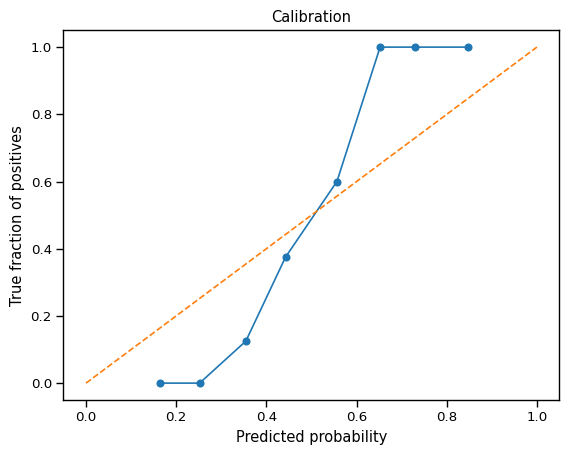

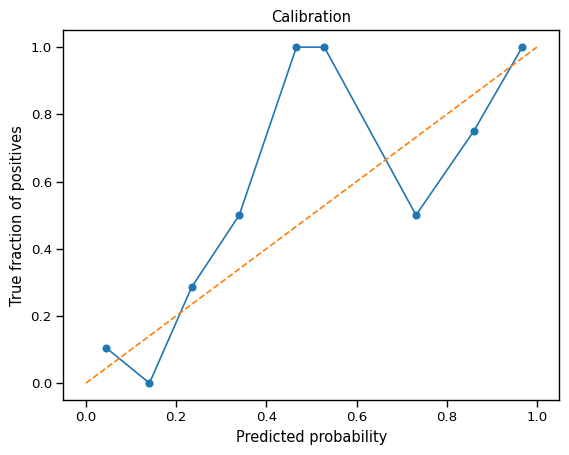

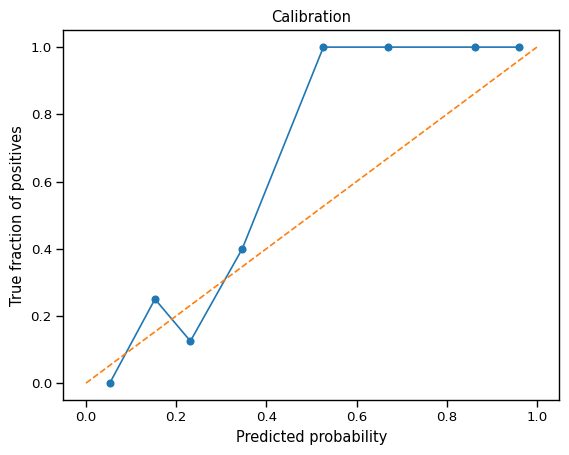

In [81]:
from sklearn.calibration import calibration_curve
# Calibration Curve
for name,a in modeles.items():
    prob_pos = a.predict_proba(x_test)[:, 1]
    frac_pos, mean_pred = calibration_curve(y_test, prob_pos, n_bins=10, strategy='uniform')
    plt.plot(mean_pred, frac_pos, marker='o'); plt.plot([0,1],[0,1],'--')
    plt.xlabel('Predicted probability'); plt.ylabel('True fraction of positives'); plt.title('Calibration'); plt.show()

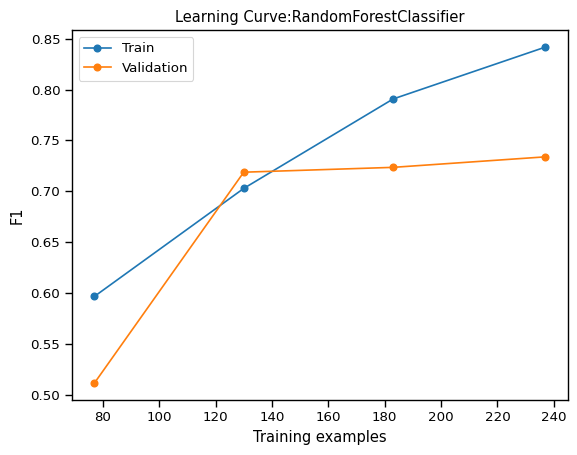

d:\python for data science\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning:


1 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "d:\python for data science\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\python for data science\.venv\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\python for data science\.venv\Lib\site-packages\sklearn\ensemble\_gb.py", line 669, i

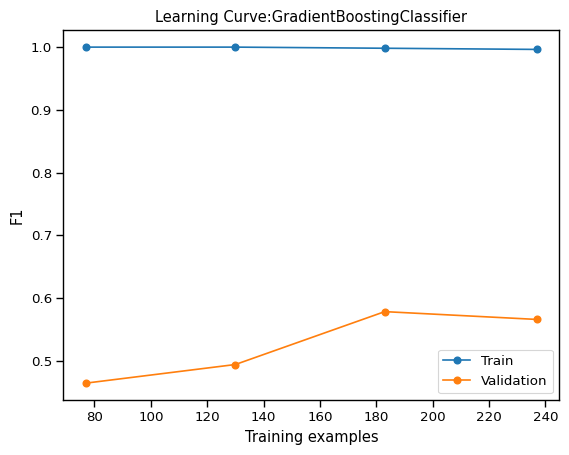

d:\python for data science\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning:


1 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "d:\python for data science\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\python for data science\.venv\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\python for data science\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py", l

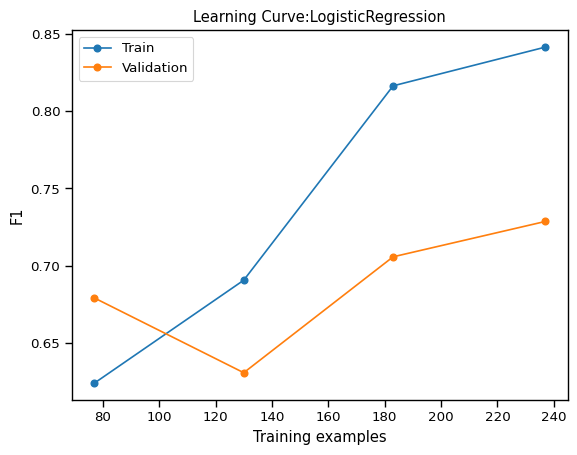

In [82]:
for name,a in modeles.items():
    train_sizes, train_scores, val_scores = learning_curve(
        a, x, y, cv=5, scoring='f1', train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1)
    plt.plot(train_sizes, train_scores.mean(axis=1), marker='o', label='Train')
    plt.plot(train_sizes, val_scores.mean(axis=1), marker='o', label='Validation')
    plt.xlabel('Training examples'); plt.ylabel('F1'); plt.title(f'Learning Curve:{name}'); plt.legend(); plt.show()


In [83]:
import pickle
best_model=RandomForestClassifier()
best_model.fit(x_train,y_train)
y_pred=best_model.predict(x_test)
print(accuracy_score(y_test , y_pred))
filename='heart_disease_V2.sav'
pickle.dump(best_model , open(filename , 'wb') )

0.8833333333333333
